# London Cycling Project

### Load datasets

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap
# Ignore copy warning
pd.options.mode.chained_assignment = None 

In [2]:
# Load London data 
inner = pd.read_csv('London/inner.csv')
outer = pd.read_csv('London/Outer London.csv')
central = pd.read_csv('London/central.csv')
sites = pd.read_excel('London/Biking sites.xlsx')

In [3]:
# Set up Easting/Northing to Latitude/Longitude converter
transformer = Transformer.from_crs('epsg:27700', 'epsg:4326')

# Get coordinates of sites 
sites['coordinates'] = ''
for i in range(sites.shape[0]):
    sites['coordinates'][i] = transformer.transform(sites.Easting[i], sites.Northing[i])

In [4]:
# Add columns 
central['area'] = 'Central'
inner['area'] = 'Inner'
outer['area'] = 'Outer'
central['Survey wave (year)'] = [central['Survey wave (calendar quarter)'][i].split()[0] 
                                 for i in range(central.shape[0])]

In [5]:
# Join London dataframes 
london = pd.concat([central, inner, outer]).reset_index(drop=True)

In [6]:
# Get day of week and date from survey date column

london['Survey date'].replace(' ', np.NaN, inplace=True)
london['Survey date'] = london['Survey date'].fillna(', ')

london['days'] = [london['Survey date'][i].split(', ')[0] for i in range(london.shape[0])]
london['date'] = [london['Survey date'][i].split(', ')[1] for i in range(london.shape[0])]

london['Survey date'].replace(', ', np.NaN, inplace=True)

day_mapping = {
    'lun' : 'Monday',
    'mar' : 'Tuesday',
    'mer' : 'Wednesday',
    'jeu' : 'Thursday',
    'ven' : 'Friday',
    'sam' : 'Saturday',
    'dim' : 'Sunday',
    '' : np.NaN
}

london['day_of_week'] = london['days'].map(day_mapping)
london.date.replace('', np.nan, inplace=True)
london.drop(['Survey date', 'days'], axis=1, inplace=True)

In [7]:
# Drop columns that may be less important in analysis 
london = london.drop(['Survey wave (calendar quarter)', 'Equivalent financial quarter', 'Location', 
                      'Time', 'Direction', 'Start minute', 'Number of unknown cycles'], axis=1)

In [8]:
# Rename columns 
london.rename(columns={'Site ID':'site', 'Weather':'weather', 'Period':'period', 'Start hour':'hour', 
                       'Number of private cycles':'private', 'Number of cycle hire bikes':'hired', 
                       'Total cycles':'total_cycles', 'Survey wave (year)':'year', 'Number of male cycles':'male',
                       'Number of female cycles':'female'}, inplace=True)

In [9]:
# Standardise weather 
london.weather = london.weather.str.lower()
london.weather = london.weather.fillna('')

wet_list = ['wet', 'rain', 'drizz', 'shower', 'damp', 'mizzle', 'down pour', 'deluge', 'spit', ' shr']
good_list = ['sun', 'fine', 'fair', 'warm', 'hot', 'good', 'mild', 'clear', 'bright']
poor_list = ['cloud', 'overcast', 'cold', 'cool', 'wind', 'dull', 'dark', 'chill', 'hazy', 'foggy', 
             'blustery', 'mist', 'snow', 'hail', 'sleet', 'storm', 'thunder']

weather_cat = []
for weather_text in london.weather:
    if any(word in weather_text for word in wet_list) and 'dry' in weather_text:
        weather_cat.append('mixed')
    elif 'dry' in weather_text:
        weather_cat.append('dry')
    elif any(word in weather_text for word in wet_list):
        weather_cat.append('wet')
    elif (any(word in weather_text for word in good_list) and any(word in weather_text for word in poor_list)) or weather_text == 'mixed':
        weather_cat.append('mixed')       
    elif any(word in weather_text for word in good_list):
        weather_cat.append('good')        
    elif any(word in weather_text for word in poor_list):
        weather_cat.append('poor')       
    else:
        weather_cat.append(np.nan)    
        
london['weather'] = weather_cat

In [10]:
# Convert date data 
london['date'] = pd.to_datetime(london['date'], errors='coerce')
london['month'] = london['date'].dt.month

# Convert year from object to integer type
london = london.astype({'year':'int'})

In [11]:
# Get borough and coordinate data  
site_data = sites[['UnqID', 'Borough', 'coordinates']].rename(columns={'UnqID':'site', 'Borough':'borough'})
london = london.merge(site_data, how='left', on='site')

In [12]:
# Checking for unexpected values 
for col in london.columns:
    print(london[col].value_counts())

# Checking null values 
print(london.isna().sum())

# View dataset
print(london.shape)
london.head()

CENCY008    3714
CENCY001    3712
CENCY136    3712
CENCY125    3712
CENCY126    3712
            ... 
INNCY479     640
INNCY492     640
INNCY455     640
INNCY463     640
INNCY502     640
Name: site, Length: 1258, dtype: int64
dry      1385589
wet       194965
good       37002
poor       13044
mixed       4637
Name: weather, dtype: int64
Inter-peak (10:00-16:00)       621642
AM peak (07:00-10:00)          310824
PM peak (16:00-19:00)          310781
Evening (19:00-22:00)          310738
Early Morning (06:00-07:00)    103608
Name: period, dtype: int64
6.0     103608
7.0     103608
8.0     103608
9.0     103608
10.0    103608
11.0    103608
12.0    103608
13.0    103608
14.0    103605
15.0    103605
16.0    103604
18.0    103589
17.0    103588
19.0    103584
20.0    103580
21.0    103574
Name: hour, dtype: int64
0.0      200509
1.0      144984
2.0      117913
3.0       93606
4.0       80113
          ...  
476.0         1
362.0         1
428.0         1
512.0         1
378.0         1
Nam

,site,weather,period,hour,private,hired,total_cycles,area,year,male,female,date,day_of_week,month,borough,coordinates
0,CENCY001,dry,Early Morning (06:00-07:00),6.0,0.0,0.0,0,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"
1,CENCY001,dry,Early Morning (06:00-07:00),6.0,15.0,0.0,15,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"
2,CENCY001,dry,Early Morning (06:00-07:00),6.0,35.0,0.0,35,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"
3,CENCY001,dry,Early Morning (06:00-07:00),6.0,59.0,2.0,61,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"
4,CENCY001,dry,AM peak (07:00-10:00),7.0,73.0,0.0,73,Central,2014,NaN,NaN,2014-01-24,Friday,1.0,Westminster,"(51.49263181884167, -0.12519636637232098)"


### Differences

We observe that there are more male than female cyclists, and more cyclists using private than hired bicycles.

What are the possible reasons for this? Can we make any recommendations to increase cycling levels?

Text(0.5, 0, 'Number of cyclists')

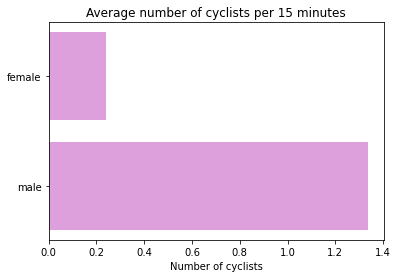

In [13]:
# Male vs female cyclists (Outer London)
sex_df = pd.DataFrame(london[['male', 'female']].mean(), columns=['mean']).reset_index()
plt.barh(sex_df['index'], sex_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

Text(0.5, 0, 'Number of cyclists')

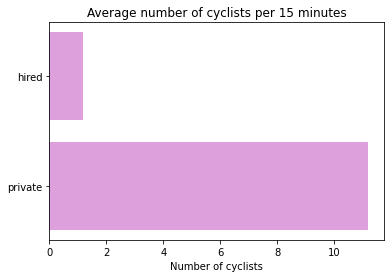

In [14]:
# Private vs hired cycles (Inner and Central London)
private_df = pd.DataFrame(london[['private', 'hired']].mean(), columns=['mean']).reset_index()
plt.barh(private_df['index'], private_df['mean'], color = 'plum')
plt.title('Average number of cyclists per 15 minutes')
plt.xlabel('Number of cyclists')

### Modelling

We would like to predict the number of cyclists in a 15 minute period, based on the features available. We would then like to extend this model to look at the proximity to various infrastructure, based on the coordinates.

In [49]:
# Select features for model 
london_model = london[['year', 'month', 'day_of_week', 'period', 'hour', 'area', 'borough', 'weather', 'total_cycles']]

# Exclude rows with null values 
london_model = london_model.dropna()

# ~1.6% of total rows dropped
(london_model.shape[0]/london.shape[0])*100

98.41891796508082

In [50]:
# Change month column from float to int
london_model.month = london_model.month.astype(int)

# Set categorical categories as category 
cat_cols = ['month', 'day_of_week', 'period', 'area', 'borough', 'weather']
for col in cat_cols:
    london_model[col] = london_model[col].astype('category')
    london_model[col] = london_model[col].cat.codes

# Record categorical columns 
cat_index = []
for col in cat_cols:
    cat_index.append(london_model.columns.get_loc(col))

In [42]:
# CatBoost model 
X = london_model.drop(['total_cycles'], axis=1)
y = london_model.total_cycles

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
train_dataset = cb.Pool(X_train, y_train, cat_features=cat_index) 
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_index)

model = cb.CatBoostRegressor(loss_function='Poisson')
grid = {'iterations': [400],
        'learning_rate': [0.3],
        'depth': [10],
        'early_stopping_rounds' : [10]}
model.grid_search(grid, train_dataset)

0:	learn: -6.3185724	test: -6.3201509	best: -6.3201509 (0)	total: 1.56s	remaining: 10m 21s
1:	learn: -10.9312448	test: -10.9338022	best: -10.9338022 (1)	total: 2.99s	remaining: 9m 55s
2:	learn: -13.7073986	test: -13.7096780	best: -13.7096780 (2)	total: 4.13s	remaining: 9m 6s
3:	learn: -15.3134664	test: -15.3141744	best: -15.3141744 (3)	total: 5.78s	remaining: 9m 31s
4:	learn: -16.2157102	test: -16.2167430	best: -16.2167430 (4)	total: 7.38s	remaining: 9m 43s
5:	learn: -16.7677047	test: -16.7688960	best: -16.7688960 (5)	total: 8.83s	remaining: 9m 40s
6:	learn: -17.0758051	test: -17.0772394	best: -17.0772394 (6)	total: 10.2s	remaining: 9m 32s
7:	learn: -17.2515089	test: -17.2507535	best: -17.2507535 (7)	total: 11.6s	remaining: 9m 26s
8:	learn: -17.3760146	test: -17.3766354	best: -17.3766354 (8)	total: 13.1s	remaining: 9m 28s
9:	learn: -17.4455564	test: -17.4459920	best: -17.4459920 (9)	total: 14.7s	remaining: 9m 31s
10:	learn: -17.5174706	test: -17.5179117	best: -17.5179117 (10)	total: 15

86:	learn: -18.2935062	test: -18.1930993	best: -18.1930993 (86)	total: 2m 55s	remaining: 10m 30s
87:	learn: -18.2970127	test: -18.1970257	best: -18.1970257 (87)	total: 2m 56s	remaining: 10m 26s
88:	learn: -18.3064134	test: -18.2049697	best: -18.2049697 (88)	total: 2m 59s	remaining: 10m 26s
89:	learn: -18.3123773	test: -18.2099640	best: -18.2099640 (89)	total: 3m 2s	remaining: 10m 27s
90:	learn: -18.3196785	test: -18.2156163	best: -18.2156163 (90)	total: 3m 4s	remaining: 10m 26s
91:	learn: -18.3198874	test: -18.2156036	best: -18.2156163 (90)	total: 3m 6s	remaining: 10m 25s
92:	learn: -18.3226898	test: -18.2164973	best: -18.2164973 (92)	total: 3m 8s	remaining: 10m 22s
93:	learn: -18.3230301	test: -18.2165547	best: -18.2165547 (93)	total: 3m 10s	remaining: 10m 20s
94:	learn: -18.3266872	test: -18.2173898	best: -18.2173898 (94)	total: 3m 12s	remaining: 10m 19s
95:	learn: -18.3320465	test: -18.2214548	best: -18.2214548 (95)	total: 3m 15s	remaining: 10m 17s
96:	learn: -18.3369995	test: -18.2

171:	learn: -18.5906547	test: -18.3668432	best: -18.3668768 (170)	total: 6m 10s	remaining: 8m 10s
172:	learn: -18.5915268	test: -18.3669883	best: -18.3669883 (172)	total: 6m 12s	remaining: 8m 8s
173:	learn: -18.5920733	test: -18.3675506	best: -18.3675506 (173)	total: 6m 13s	remaining: 8m 5s
174:	learn: -18.5941999	test: -18.3681706	best: -18.3681706 (174)	total: 6m 16s	remaining: 8m 4s
175:	learn: -18.5954690	test: -18.3680069	best: -18.3681706 (174)	total: 6m 18s	remaining: 8m 1s
176:	learn: -18.6015708	test: -18.3741623	best: -18.3741623 (176)	total: 6m 21s	remaining: 8m
177:	learn: -18.6033006	test: -18.3740959	best: -18.3741623 (176)	total: 6m 23s	remaining: 7m 57s
178:	learn: -18.6063048	test: -18.3739227	best: -18.3741623 (176)	total: 6m 25s	remaining: 7m 55s
179:	learn: -18.6089337	test: -18.3762249	best: -18.3762249 (179)	total: 6m 27s	remaining: 7m 53s
180:	learn: -18.6090098	test: -18.3762810	best: -18.3762810 (180)	total: 6m 29s	remaining: 7m 51s
181:	learn: -18.6148629	test

255:	learn: -18.7871129	test: -18.4568380	best: -18.4568380 (255)	total: 9m 29s	remaining: 5m 20s
256:	learn: -18.7892010	test: -18.4588859	best: -18.4588859 (256)	total: 9m 31s	remaining: 5m 18s
257:	learn: -18.7894380	test: -18.4586903	best: -18.4588859 (256)	total: 9m 34s	remaining: 5m 15s
258:	learn: -18.7900831	test: -18.4583998	best: -18.4588859 (256)	total: 9m 36s	remaining: 5m 13s
259:	learn: -18.7916955	test: -18.4596895	best: -18.4596895 (259)	total: 9m 38s	remaining: 5m 11s
260:	learn: -18.7956637	test: -18.4623336	best: -18.4623336 (260)	total: 9m 41s	remaining: 5m 9s
261:	learn: -18.7974120	test: -18.4630507	best: -18.4630507 (261)	total: 9m 44s	remaining: 5m 7s
262:	learn: -18.7986568	test: -18.4634530	best: -18.4634530 (262)	total: 9m 46s	remaining: 5m 5s
263:	learn: -18.7998413	test: -18.4637047	best: -18.4637047 (263)	total: 9m 48s	remaining: 5m 3s
264:	learn: -18.8008955	test: -18.4640171	best: -18.4640171 (264)	total: 9m 51s	remaining: 5m 1s
265:	learn: -18.8020903	t

339:	learn: -18.8962306	test: -18.4946079	best: -18.4946079 (339)	total: 12m 41s	remaining: 2m 14s
340:	learn: -18.8981970	test: -18.4954098	best: -18.4954098 (340)	total: 12m 44s	remaining: 2m 12s
341:	learn: -18.8985031	test: -18.4956436	best: -18.4956436 (341)	total: 12m 46s	remaining: 2m 9s
342:	learn: -18.9006697	test: -18.4957017	best: -18.4957017 (342)	total: 12m 48s	remaining: 2m 7s
343:	learn: -18.9034922	test: -18.4974351	best: -18.4974351 (343)	total: 12m 50s	remaining: 2m 5s
344:	learn: -18.9036550	test: -18.4975204	best: -18.4975204 (344)	total: 12m 53s	remaining: 2m 3s
345:	learn: -18.9039244	test: -18.4975097	best: -18.4975204 (344)	total: 12m 55s	remaining: 2m 1s
346:	learn: -18.9040977	test: -18.4974054	best: -18.4975204 (344)	total: 12m 57s	remaining: 1m 58s
347:	learn: -18.9058313	test: -18.4984747	best: -18.4984747 (347)	total: 12m 59s	remaining: 1m 56s
348:	learn: -18.9080384	test: -18.4996257	best: -18.4996257 (348)	total: 13m 1s	remaining: 1m 54s
349:	learn: -18.

22:	learn: -17.7890393	test: -17.8042057	best: -17.8042057 (22)	total: 41.8s	remaining: 11m 25s
23:	learn: -17.8032094	test: -17.8142812	best: -17.8142812 (23)	total: 43.9s	remaining: 11m 27s
24:	learn: -17.8239784	test: -17.8346604	best: -17.8346604 (24)	total: 45.6s	remaining: 11m 24s
25:	learn: -17.8239954	test: -17.8346773	best: -17.8346773 (25)	total: 46.1s	remaining: 11m 3s
26:	learn: -17.8428470	test: -17.8524454	best: -17.8524454 (26)	total: 47.7s	remaining: 10m 59s
27:	learn: -17.8479240	test: -17.8569376	best: -17.8569376 (27)	total: 49.5s	remaining: 10m 58s
28:	learn: -17.8479592	test: -17.8569062	best: -17.8569376 (27)	total: 50.7s	remaining: 10m 47s
29:	learn: -17.8687055	test: -17.8722378	best: -17.8722378 (29)	total: 52.9s	remaining: 10m 52s
30:	learn: -17.8804368	test: -17.8838841	best: -17.8838841 (30)	total: 54.9s	remaining: 10m 52s
31:	learn: -17.8999157	test: -17.9004484	best: -17.9004484 (31)	total: 56.8s	remaining: 10m 53s
32:	learn: -17.9089450	test: -17.9062491	

108:	learn: -18.3859421	test: -18.2418508	best: -18.2418508 (108)	total: 3m 29s	remaining: 9m 18s
109:	learn: -18.3928935	test: -18.2465230	best: -18.2465230 (109)	total: 3m 31s	remaining: 9m 17s
110:	learn: -18.3983461	test: -18.2498683	best: -18.2498683 (110)	total: 3m 33s	remaining: 9m 17s
111:	learn: -18.3989492	test: -18.2498804	best: -18.2498804 (111)	total: 3m 35s	remaining: 9m 15s
112:	learn: -18.4014031	test: -18.2511051	best: -18.2511051 (112)	total: 3m 37s	remaining: 9m 13s
113:	learn: -18.4026271	test: -18.2517362	best: -18.2517362 (113)	total: 3m 39s	remaining: 9m 11s
114:	learn: -18.4041239	test: -18.2520530	best: -18.2520530 (114)	total: 3m 41s	remaining: 9m 9s
115:	learn: -18.4044200	test: -18.2519783	best: -18.2520530 (114)	total: 3m 43s	remaining: 9m 7s
116:	learn: -18.4069831	test: -18.2518183	best: -18.2520530 (114)	total: 3m 45s	remaining: 9m 4s
117:	learn: -18.4114135	test: -18.2532410	best: -18.2532410 (117)	total: 3m 47s	remaining: 9m 3s
118:	learn: -18.4157517	

193:	learn: -18.6520933	test: -18.3792813	best: -18.3792813 (193)	total: 6m 19s	remaining: 6m 43s
194:	learn: -18.6556417	test: -18.3808915	best: -18.3808915 (194)	total: 6m 21s	remaining: 6m 41s
195:	learn: -18.6580532	test: -18.3813884	best: -18.3813884 (195)	total: 6m 23s	remaining: 6m 38s
196:	learn: -18.6603049	test: -18.3823964	best: -18.3823964 (196)	total: 6m 25s	remaining: 6m 37s
197:	learn: -18.6606851	test: -18.3825245	best: -18.3825245 (197)	total: 6m 27s	remaining: 6m 35s
198:	learn: -18.6619184	test: -18.3830411	best: -18.3830411 (198)	total: 6m 29s	remaining: 6m 33s
199:	learn: -18.6661709	test: -18.3844614	best: -18.3844614 (199)	total: 6m 31s	remaining: 6m 31s
200:	learn: -18.6688895	test: -18.3853915	best: -18.3853915 (200)	total: 6m 33s	remaining: 6m 29s
201:	learn: -18.6719158	test: -18.3867137	best: -18.3867137 (201)	total: 6m 35s	remaining: 6m 27s
202:	learn: -18.6732529	test: -18.3869117	best: -18.3869117 (202)	total: 6m 37s	remaining: 6m 25s
203:	learn: -18.6735

277:	learn: -18.8260443	test: -18.4431498	best: -18.4431498 (277)	total: 9m 7s	remaining: 4m
278:	learn: -18.8313320	test: -18.4468016	best: -18.4468016 (278)	total: 9m 9s	remaining: 3m 58s
279:	learn: -18.8344265	test: -18.4492053	best: -18.4492053 (279)	total: 9m 11s	remaining: 3m 56s
280:	learn: -18.8365166	test: -18.4494375	best: -18.4494375 (280)	total: 9m 13s	remaining: 3m 54s
281:	learn: -18.8396107	test: -18.4503311	best: -18.4503311 (281)	total: 9m 15s	remaining: 3m 52s
282:	learn: -18.8407281	test: -18.4501696	best: -18.4503311 (281)	total: 9m 17s	remaining: 3m 50s
283:	learn: -18.8425618	test: -18.4506103	best: -18.4506103 (283)	total: 9m 19s	remaining: 3m 48s
284:	learn: -18.8430569	test: -18.4499969	best: -18.4506103 (283)	total: 9m 20s	remaining: 3m 46s
285:	learn: -18.8455912	test: -18.4486747	best: -18.4506103 (283)	total: 9m 23s	remaining: 3m 44s
286:	learn: -18.8464421	test: -18.4483131	best: -18.4506103 (283)	total: 9m 25s	remaining: 3m 42s
287:	learn: -18.8475984	te

361:	learn: -18.9690681	test: -18.4898931	best: -18.4898931 (361)	total: 11m 59s	remaining: 1m 15s
362:	learn: -18.9720016	test: -18.4908853	best: -18.4908853 (362)	total: 12m 1s	remaining: 1m 13s
363:	learn: -18.9731624	test: -18.4909096	best: -18.4909096 (363)	total: 12m 3s	remaining: 1m 11s
364:	learn: -18.9745086	test: -18.4914674	best: -18.4914674 (364)	total: 12m 6s	remaining: 1m 9s
365:	learn: -18.9748176	test: -18.4913942	best: -18.4914674 (364)	total: 12m 8s	remaining: 1m 7s
366:	learn: -18.9750538	test: -18.4915655	best: -18.4915655 (366)	total: 12m 10s	remaining: 1m 5s
367:	learn: -18.9754824	test: -18.4916855	best: -18.4916855 (367)	total: 12m 11s	remaining: 1m 3s
368:	learn: -18.9763819	test: -18.4923197	best: -18.4923197 (368)	total: 12m 13s	remaining: 1m 1s
369:	learn: -18.9768131	test: -18.4923607	best: -18.4923607 (369)	total: 12m 15s	remaining: 59.6s
370:	learn: -18.9775968	test: -18.4916073	best: -18.4923607 (369)	total: 12m 17s	remaining: 57.6s
371:	learn: -18.98126

46:	learn: -18.0078370	test: -18.0410175	best: -18.0410175 (46)	total: 1m 26s	remaining: 10m 50s
47:	learn: -18.0149862	test: -18.0465606	best: -18.0465606 (47)	total: 1m 28s	remaining: 10m 50s
48:	learn: -18.0240230	test: -18.0501212	best: -18.0501212 (48)	total: 1m 30s	remaining: 10m 51s
49:	learn: -18.0450504	test: -18.0666491	best: -18.0666491 (49)	total: 1m 33s	remaining: 10m 52s
50:	learn: -18.0548405	test: -18.0746309	best: -18.0746309 (50)	total: 1m 35s	remaining: 10m 52s
51:	learn: -18.0597966	test: -18.0778199	best: -18.0778199 (51)	total: 1m 37s	remaining: 10m 50s
52:	learn: -18.0625327	test: -18.0800550	best: -18.0800550 (52)	total: 1m 38s	remaining: 10m 48s
53:	learn: -18.0654421	test: -18.0815752	best: -18.0815752 (53)	total: 1m 41s	remaining: 10m 48s
54:	learn: -18.0703693	test: -18.0856037	best: -18.0856037 (54)	total: 1m 43s	remaining: 10m 49s
55:	learn: -18.0778719	test: -18.0896730	best: -18.0896730 (55)	total: 1m 45s	remaining: 10m 49s
56:	learn: -18.0812767	test: -

131:	learn: -18.4476610	test: -18.3251509	best: -18.3251509 (131)	total: 4m 14s	remaining: 8m 35s
132:	learn: -18.4543742	test: -18.3287332	best: -18.3287332 (132)	total: 4m 16s	remaining: 8m 34s
133:	learn: -18.4602137	test: -18.3334943	best: -18.3334943 (133)	total: 4m 17s	remaining: 8m 31s
134:	learn: -18.4621202	test: -18.3341807	best: -18.3341807 (134)	total: 4m 20s	remaining: 8m 30s
135:	learn: -18.4652946	test: -18.3341838	best: -18.3341838 (135)	total: 4m 23s	remaining: 8m 30s
136:	learn: -18.4661355	test: -18.3346061	best: -18.3346061 (136)	total: 4m 25s	remaining: 8m 29s
137:	learn: -18.4671632	test: -18.3347944	best: -18.3347944 (137)	total: 4m 27s	remaining: 8m 27s
138:	learn: -18.4676600	test: -18.3349413	best: -18.3349413 (138)	total: 4m 29s	remaining: 8m 25s
139:	learn: -18.4697089	test: -18.3359508	best: -18.3359508 (139)	total: 4m 30s	remaining: 8m 23s
140:	learn: -18.4725299	test: -18.3369326	best: -18.3369326 (140)	total: 4m 32s	remaining: 8m 21s
141:	learn: -18.4740

215:	learn: -18.6908483	test: -18.4423925	best: -18.4423925 (215)	total: 7m 3s	remaining: 6m
216:	learn: -18.6913248	test: -18.4425651	best: -18.4425651 (216)	total: 7m 5s	remaining: 5m 58s
217:	learn: -18.6918496	test: -18.4428051	best: -18.4428051 (217)	total: 7m 7s	remaining: 5m 56s
218:	learn: -18.6919640	test: -18.4428508	best: -18.4428508 (218)	total: 7m 8s	remaining: 5m 54s
219:	learn: -18.6926859	test: -18.4427904	best: -18.4428508 (218)	total: 7m 10s	remaining: 5m 52s
220:	learn: -18.6945203	test: -18.4435805	best: -18.4435805 (220)	total: 7m 12s	remaining: 5m 50s
221:	learn: -18.6953563	test: -18.4433795	best: -18.4435805 (220)	total: 7m 14s	remaining: 5m 48s
222:	learn: -18.6967154	test: -18.4437751	best: -18.4437751 (222)	total: 7m 16s	remaining: 5m 46s
223:	learn: -18.6973264	test: -18.4437769	best: -18.4437769 (223)	total: 7m 18s	remaining: 5m 44s
224:	learn: -18.7001613	test: -18.4451754	best: -18.4451754 (224)	total: 7m 20s	remaining: 5m 42s
225:	learn: -18.7009179	test

299:	learn: -18.8468702	test: -18.5072357	best: -18.5072783 (298)	total: 9m 48s	remaining: 3m 16s
300:	learn: -18.8484179	test: -18.5075727	best: -18.5075727 (300)	total: 9m 50s	remaining: 3m 14s
301:	learn: -18.8524767	test: -18.5102465	best: -18.5102465 (301)	total: 9m 52s	remaining: 3m 12s
302:	learn: -18.8535428	test: -18.5110919	best: -18.5110919 (302)	total: 9m 54s	remaining: 3m 10s
303:	learn: -18.8556371	test: -18.5108751	best: -18.5110919 (302)	total: 9m 55s	remaining: 3m 8s
304:	learn: -18.8600250	test: -18.5137801	best: -18.5137801 (304)	total: 9m 58s	remaining: 3m 6s
305:	learn: -18.8628481	test: -18.5156113	best: -18.5156113 (305)	total: 10m	remaining: 3m 4s
306:	learn: -18.8654896	test: -18.5165285	best: -18.5165285 (306)	total: 10m 2s	remaining: 3m 2s
307:	learn: -18.8663481	test: -18.5168442	best: -18.5168442 (307)	total: 10m 4s	remaining: 3m
308:	learn: -18.8671816	test: -18.5170139	best: -18.5170139 (308)	total: 10m 6s	remaining: 2m 58s
309:	learn: -18.8684834	test: -

383:	learn: -18.9857766	test: -18.5576734	best: -18.5576734 (383)	total: 12m 34s	remaining: 31.4s
384:	learn: -18.9872870	test: -18.5575844	best: -18.5576734 (383)	total: 12m 36s	remaining: 29.5s
385:	learn: -18.9894621	test: -18.5576744	best: -18.5576744 (385)	total: 12m 39s	remaining: 27.5s
386:	learn: -18.9900638	test: -18.5577932	best: -18.5577932 (386)	total: 12m 41s	remaining: 25.6s
387:	learn: -18.9910580	test: -18.5576989	best: -18.5577932 (386)	total: 12m 43s	remaining: 23.6s
388:	learn: -18.9925989	test: -18.5578272	best: -18.5578272 (388)	total: 12m 44s	remaining: 21.6s
389:	learn: -18.9930198	test: -18.5581641	best: -18.5581641 (389)	total: 12m 45s	remaining: 19.6s
390:	learn: -18.9930443	test: -18.5581871	best: -18.5581871 (390)	total: 12m 47s	remaining: 17.7s
391:	learn: -18.9942804	test: -18.5578299	best: -18.5581871 (390)	total: 12m 49s	remaining: 15.7s
392:	learn: -18.9964977	test: -18.5584777	best: -18.5584777 (392)	total: 12m 51s	remaining: 13.7s
393:	learn: -18.9978

68:	learn: -18.2488240	test: -18.0018311	best: -18.0018311 (68)	total: 2m 9s	remaining: 10m 22s
69:	learn: -18.2561968	test: -18.0065054	best: -18.0065054 (69)	total: 2m 11s	remaining: 10m 21s
70:	learn: -18.2586827	test: -18.0073819	best: -18.0073819 (70)	total: 2m 13s	remaining: 10m 19s
71:	learn: -18.2599769	test: -18.0082874	best: -18.0082874 (71)	total: 2m 15s	remaining: 10m 17s
72:	learn: -18.2637132	test: -18.0102748	best: -18.0102748 (72)	total: 2m 17s	remaining: 10m 15s
73:	learn: -18.2742931	test: -18.0166199	best: -18.0166199 (73)	total: 2m 19s	remaining: 10m 14s
74:	learn: -18.2832412	test: -18.0238251	best: -18.0238251 (74)	total: 2m 21s	remaining: 10m 13s
75:	learn: -18.2841833	test: -18.0241140	best: -18.0241140 (75)	total: 2m 23s	remaining: 10m 10s
76:	learn: -18.2932804	test: -18.0304925	best: -18.0304925 (76)	total: 2m 25s	remaining: 10m 9s
77:	learn: -18.2986556	test: -18.0329252	best: -18.0329252 (77)	total: 2m 27s	remaining: 10m 8s
78:	learn: -18.3021088	test: -18.

153:	learn: -18.6199716	test: -18.2102113	best: -18.2102113 (153)	total: 4m 51s	remaining: 7m 44s
154:	learn: -18.6238463	test: -18.2133194	best: -18.2133194 (154)	total: 4m 52s	remaining: 7m 42s
155:	learn: -18.6277146	test: -18.2144392	best: -18.2144392 (155)	total: 4m 54s	remaining: 7m 39s
156:	learn: -18.6319128	test: -18.2169439	best: -18.2169439 (156)	total: 4m 55s	remaining: 7m 37s
157:	learn: -18.6330537	test: -18.2171261	best: -18.2171261 (157)	total: 4m 56s	remaining: 7m 34s
158:	learn: -18.6384785	test: -18.2192986	best: -18.2192986 (158)	total: 4m 58s	remaining: 7m 31s
159:	learn: -18.6450470	test: -18.2203846	best: -18.2203846 (159)	total: 4m 59s	remaining: 7m 29s
160:	learn: -18.6468348	test: -18.2213048	best: -18.2213048 (160)	total: 5m 1s	remaining: 7m 27s
161:	learn: -18.6494875	test: -18.2230212	best: -18.2230212 (161)	total: 5m 2s	remaining: 7m 24s
162:	learn: -18.6498697	test: -18.2231948	best: -18.2231948 (162)	total: 5m 4s	remaining: 7m 22s
163:	learn: -18.6503805

237:	learn: -18.8328135	test: -18.3052894	best: -18.3052894 (237)	total: 6m 52s	remaining: 4m 41s
238:	learn: -18.8348949	test: -18.3064382	best: -18.3064382 (238)	total: 6m 54s	remaining: 4m 39s
239:	learn: -18.8369112	test: -18.3062353	best: -18.3064382 (238)	total: 6m 55s	remaining: 4m 37s
240:	learn: -18.8370380	test: -18.3062421	best: -18.3064382 (238)	total: 6m 57s	remaining: 4m 35s
241:	learn: -18.8379386	test: -18.3066684	best: -18.3066684 (241)	total: 6m 58s	remaining: 4m 33s
242:	learn: -18.8399282	test: -18.3075109	best: -18.3075109 (242)	total: 7m	remaining: 4m 31s
243:	learn: -18.8399946	test: -18.3075349	best: -18.3075349 (243)	total: 7m 1s	remaining: 4m 29s
244:	learn: -18.8415304	test: -18.3072862	best: -18.3075349 (243)	total: 7m 2s	remaining: 4m 27s
245:	learn: -18.8437915	test: -18.3077054	best: -18.3077054 (245)	total: 7m 4s	remaining: 4m 25s
246:	learn: -18.8461471	test: -18.3085321	best: -18.3085321 (246)	total: 7m 5s	remaining: 4m 23s
247:	learn: -18.8489920	test

321:	learn: -18.9685791	test: -18.3421758	best: -18.3421758 (321)	total: 8m 53s	remaining: 2m 9s
322:	learn: -18.9702468	test: -18.3424443	best: -18.3424443 (322)	total: 8m 55s	remaining: 2m 7s
323:	learn: -18.9704140	test: -18.3423616	best: -18.3424443 (322)	total: 8m 56s	remaining: 2m 5s
324:	learn: -18.9705770	test: -18.3422483	best: -18.3424443 (322)	total: 8m 57s	remaining: 2m 4s
325:	learn: -18.9708301	test: -18.3422503	best: -18.3424443 (322)	total: 8m 59s	remaining: 2m 2s
326:	learn: -18.9718718	test: -18.3421409	best: -18.3424443 (322)	total: 9m	remaining: 2m
327:	learn: -18.9725025	test: -18.3421127	best: -18.3424443 (322)	total: 9m 1s	remaining: 1m 58s
328:	learn: -18.9739788	test: -18.3406818	best: -18.3424443 (322)	total: 9m 2s	remaining: 1m 57s
329:	learn: -18.9755667	test: -18.3400439	best: -18.3424443 (322)	total: 9m 4s	remaining: 1m 55s
330:	learn: -18.9760317	test: -18.3399668	best: -18.3424443 (322)	total: 9m 6s	remaining: 1m 53s
331:	learn: -18.9794648	test: -18.340

{'params': {'depth': 10,
  'od_wait': 10,
  'iterations': 400,
  'learning_rate': 0.3},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
 

In [45]:
# Model performance
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r_squared = r2_score(y_test, pred)
print(f'RMSE: {rmse}')
print(f'R Squared: {r_squared}')

# ~37.7% of variance in cycling numbers explained by these factors 

RMSE: 16.944855527883863
R Squared: 0.3768976526877795


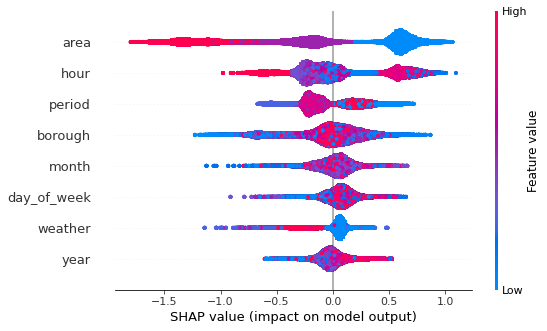

In [44]:
# Feature importance
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

### Plan for London data:

#### Steps completed:
- build some basic plots to show differences in cyclists (male/female, private/hired)
- use Python package to get coordinates of count sites 
- build a model to show differences in number of cyclists (weather? area? hour?)

#### Steps in progress: 
- clean and join infrastructure data to london data using coordinates 
- build a model to show differences in cyclists with this new data 